In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes as ax
import pyodbc
import math
import os
import datetime as dt
import sidetable as stb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

#### Importacion de datos y limpieza

In [3]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

SELECT c.CustomerId, ISNULL(sum(s.ProductWeightGrams* s.Amount * 0.001),0) 'kilos',
DATEDIFF(MONTH,c.ActivatedDate,getdate()) 'meses_desde_alta',
ISNULL(DATEDIFF(MONTH,min(s.SaleDate),max(s.SaleDate)),0) 'meses_activo',
ISNULL(DATEDIFF(MONTH,min(s.SaleDate),getdate()),0) 'meses_desde_ult_compra',
ISNULL(COUNT(DISTINCT s.SaleId),0) 'cantidad_compras',
ISNULL(COUNT(DISTINCT s.PromotionId),0) 'cantidad_promos',
ISNULL(seg.categoria, 'ABANDONO') 'categoria',
ISNULL(seg.Kilos, 0) 'kilos_ult_año',
c.GenderCode, c.BirthDate,CONVERT(DATE,c.ActivatedDate) 'fecha_activacion', convert(DATE, max(s.SaleDate)) 'ultima_compra'

FROM dbo.Customer c
LEFT JOIN dbo.SaleCustomer SC ON sc.CustomerId = c.CustomerId
LEFT JOIN dbo.Sale s ON s.SaleId=sc.SaleId
LEFT JOIN dbo.Clientes_Segmentacion_2022 seg ON c.CustomerId = seg.CustomerId
GROUP BY c.CustomerId,seg.categoria,c.GenderCode, c.BirthDate, c.ActivatedDate,seg.Kilos
"""
df = pd.read_sql(sql, conn)
df.head()

,CustomerId,kilos,meses_desde_alta,meses_activo,meses_desde_ult_compra,cantidad_compras,cantidad_promos,categoria,kilos_ult_año,GenderCode,BirthDate,fecha_activacion,ultima_compra
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,31.120,102,100,102,58,2,PLATA,0.820,Female,1984-06-21,2013-12-03,2022-04-03
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,94.061,103,100,103,28,10,ORO,20.995,Male,1975-05-12,2013-11-29,2022-03-21
2,10C29CB8-C4F5-C071-3842-08D0BF4D95AE,15.990,103,71,103,11,3,ABANDONO,0.000,Female,1980-09-17,2013-11-29,2019-10-30
3,DE3B393D-8E46-C831-D611-08D0BF3B6F0A,1.560,103,16,71,2,0,ABANDONO,0.000,Female,1959-08-22,2013-11-29,2017-11-27
4,6ACC86A5-45BC-C851-BE13-08D0BF45D4BD,15.134,103,98,103,16,4,BRONCE,1.470,Female,1983-09-16,2013-11-29,2022-01-30


In [4]:
df.shape

(4556732, 13)

In [5]:
df.isnull().sum()

CustomerId                     0
kilos                          0
meses_desde_alta               0
meses_activo                   0
meses_desde_ult_compra         0
cantidad_compras               0
cantidad_promos                0
categoria                      0
kilos_ult_año                  0
GenderCode                     0
BirthDate                      0
fecha_activacion               0
ultima_compra             419672
dtype: int64

#### Empiezo con el feature engineering

Saco los meses que estuvo activo este socio (meses entre primera y ultima compra), su edad y su lifetimevalue

In [6]:
df['meses_activo'] = df['meses_activo'].astype('int')

In [7]:
df['edad'] = (dt.datetime.today() - pd.to_datetime(df.BirthDate)) / np.timedelta64(1,'Y')
df['edad'] = df['edad'].apply(np.floor).astype('int')

In [8]:
valor_kg_promedio = 800

In [9]:
df['lifetime_value_año'] = np.where(df.meses_activo == 0,0, df.kilos * 12 / df.meses_activo)

In [10]:
sns.set(rc={"axes.facecolor":"#D9D9D9","figure.facecolor":"#D9D9D9"})
sns.despine()

<Figure size 432x288 with 0 Axes>

Cantidad de socios por segmento

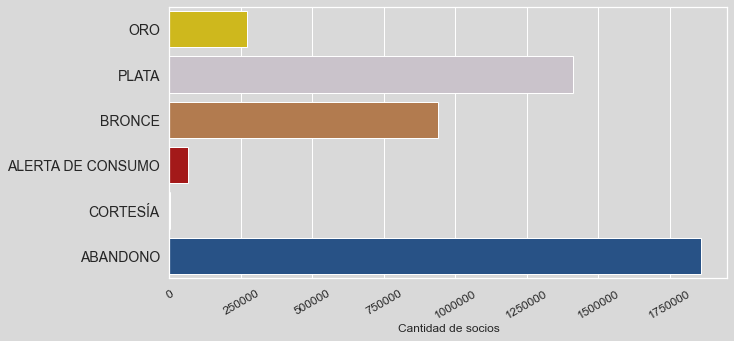

In [23]:
order= ['ORO', 'PLATA','BRONCE', 'ALERTA DE CONSUMO','CORTESÍA','ABANDONO']
pallete = ['#EBCE00','#CBC2CC','#C2793E','#BA0202','#185196','#185196']

fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30,labelsize=12)
ax.tick_params(axis='y',labelsize=14)
sns.countplot(y=df.categoria,palette=pallete,order=order)
ax.set_xlabel('Cantidad de socios',loc='center')
ax.set_ylabel('',loc='center')
plt.ticklabel_format(style='plain', axis='x')

In [24]:
df.stb.freq(['categoria'])

,categoria,count,percent,cumulative_count,cumulative_percent
0,ABANDONO,1858912,40.864720,1858912,40.864720
1,PLATA,1411365,31.026232,3270277,71.890952
2,BRONCE,940988,20.685870,4211265,92.576822
3,ORO,272391,5.988009,4483656,98.564831
4,ALERTA DE CONSUMO,64087,1.408833,4547743,99.973664
5,CORTESÍA,1198,0.026336,4548941,100.000000


## Lifetime Value

LifetimeValue por segmento y comparacion con Oro

In [67]:
order= ['ORO', 'PLATA','BRONCE', 'ALERTA DE CONSUMO','CORTESÍA','ABANDONO']
print("el valor de ciclo de vida anual promedio de un socio CG es (kg):",round(df['lifetime_value_año'].mean(),1))
for cat in order:
    print("el valor de ciclo de vida promedio de un socio CG es:",round(df[df.categoria == cat]['lifetime_value_año'].mean(),1),\
          "kg para el segmento",cat)

el valor de ciclo de vida anual promedio de un socio CG es (kg): 8.0
el valor de ciclo de vida promedio de un socio CG es: 19.6 kg para el segmento ORO
el valor de ciclo de vida promedio de un socio CG es: 7.9 kg para el segmento PLATA
el valor de ciclo de vida promedio de un socio CG es: 6.1 kg para el segmento BRONCE
el valor de ciclo de vida promedio de un socio CG es: 47.1 kg para el segmento ALERTA DE CONSUMO
el valor de ciclo de vida promedio de un socio CG es: 8.0 kg para el segmento CORTESÍA
el valor de ciclo de vida promedio de un socio CG es: 5.9 kg para el segmento ABANDONO


In [68]:
for cat in ['PLATA','BRONCE','CORTESÍA','ABANDONO']:
    print("En promedio, el segmento Oro tiene un lifetime value un",round(df[df.categoria == 'ORO']['lifetime_value_año'].mean()/df[df.categoria == cat]['lifetime_value_año'].mean()*100,0),\
          "% mayor que el segmento",cat)

En promedio, el segmento Oro tiene un lifetime value un 248.0 % mayor que el segmento PLATA
En promedio, el segmento Oro tiene un lifetime value un 323.0 % mayor que el segmento BRONCE
En promedio, el segmento Oro tiene un lifetime value un 245.0 % mayor que el segmento CORTESÍA
En promedio, el segmento Oro tiene un lifetime value un 329.0 % mayor que el segmento ABANDONO


## Churn

¿Que cantidad de meses activos lleva cada segmento?

<AxesSubplot:xlabel='meses_activo', ylabel='categoria'>

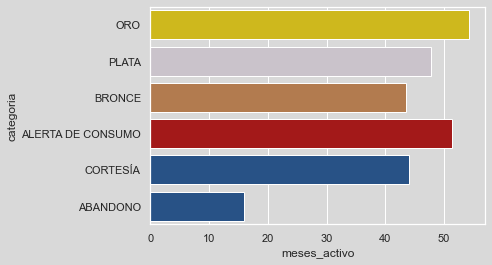

In [29]:
order= ['ORO', 'PLATA','BRONCE', 'ALERTA DE CONSUMO','CORTESÍA','ABANDONO']
pallete = ['#EBCE00','#CBC2CC','#C2793E','#BA0202','#185196','#185196']
sns.barplot(data=df.groupby('categoria')['meses_activo'].mean().reset_index(),x='meses_activo',y='categoria',\
            orient="h",order=order,palette= pallete)

<AxesSubplot:xlabel='meses_activo', ylabel='categoria'>

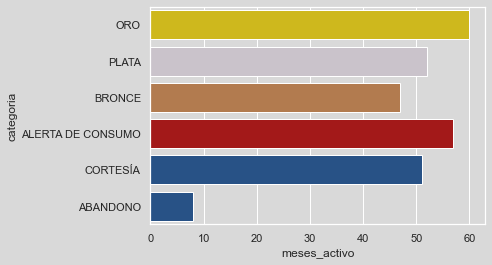

In [30]:
order= ['ORO', 'PLATA','BRONCE', 'ALERTA DE CONSUMO','CORTESÍA','ABANDONO']
pallete = ['#EBCE00','#CBC2CC','#C2793E','#BA0202','#185196','#185196']
sns.barplot(data=df.groupby('categoria')['meses_activo'].median().reset_index(),x='meses_activo',y='categoria',\
            orient="h",order=order,palette= pallete)

Para media y mediana de meses activos vemos que se cumple la jerarquia logica de ORO, PLATA, BRONCE. ALERTA DE CONSUMO es similar a ORO y CORTESIA también.

En cuanto a SOCIOS PERDIDOS, hay bastante diferencia entre la media y la mediana asi que analizaremos..

In [31]:
print('Mediana de meses activo para socios perdidos:',df[df.categoria == 'ABANDONO'].meses_activo.median())
print('Media de meses activo para socios perdidos:',df[df.categoria == 'ABANDONO'].meses_activo.mean())

Mediana de meses activo para socios perdidos: 8.0
Media de meses activo para socios perdidos: 15.913831854331997


Es probable que la distribución este sesgada hacia valores más cercanos al cero

C:\Users\pnovero\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='meses_activo'>

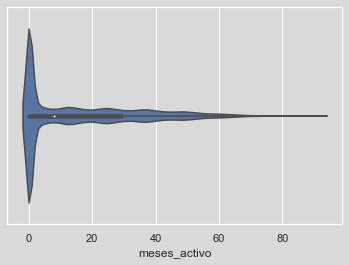

In [32]:
sns.violinplot(df[df.categoria =='ABANDONO']['meses_activo'])

C:\Users\pnovero\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 30.0)

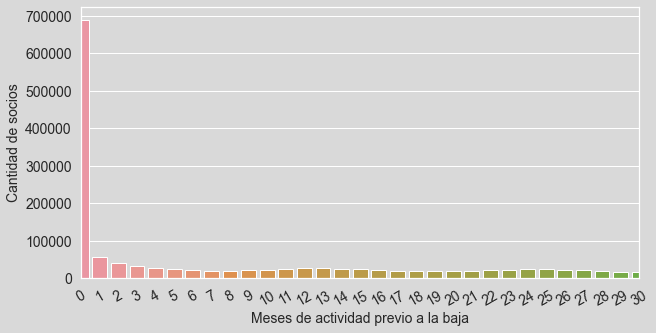

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30,labelsize=14)
ax.tick_params(axis='y',labelsize=14)
fig = sns.countplot(df[df.categoria =='ABANDONO']['meses_activo'])

ax.set_ylabel('Cantidad de socios',loc='center',fontsize=14)
ax.set_xlabel('Meses de actividad previo a la baja',loc='center',fontsize=14)
#plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0,30)

Vemos gran cantidad de socios con 0 y 1 mes activo, filtro la tabla y veo algun comportamiento extraño

In [34]:
print('socios que compraron 1 promocion como socios completos y no volvieron',df[((df.cantidad_compras == 1) & (df.meses_activo == 0) & (df.cantidad_promos == 1))].shape[0])

socios que compraron 1 promocion como socios completos y no volvieron 70732


In [35]:
print('socios que no compraron nunca como socios completos:', df[((df.cantidad_compras == 0) & (df.categoria == 'ABANDONO'))].shape[0])

socios que no compraron nunca como socios completos: 417376


In [36]:
print('socios que solo estuvieron activos 1 mes:', df[((df.meses_activo == 0) & (df.categoria == 'ABANDONO'))].shape[0])

socios que solo estuvieron activos 1 mes: 689898


In [37]:
print('socios que tienen 15 o mas compras:', df[((df.cantidad_compras >= 15) & (df.categoria == 'ABANDONO'))].shape[0])

socios que tienen 15 o mas compras: 315513


In [38]:
print('Kg promedio de socios que tienen 15 o mas compras:', df[((df.cantidad_compras >= 15) & (df.categoria == 'ABANDONO'))].kilos.mean())
print('Kg mediana de socios que tienen 15 o mas compras:', df[((df.cantidad_compras >= 15) & (df.categoria == 'ABANDONO'))].kilos.median())

Kg promedio de socios que tienen 15 o mas compras: 33.012141179604704
Kg mediana de socios que tienen 15 o mas compras: 23.866


In [39]:
#df[~((df.meses_activo == 0) & (df.cantidad_promos == 1))].edad.median()
df[df.categoria == 'ABANDONO'].cantidad_compras.median()

3.0

C:\Users\pnovero\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 30.0)

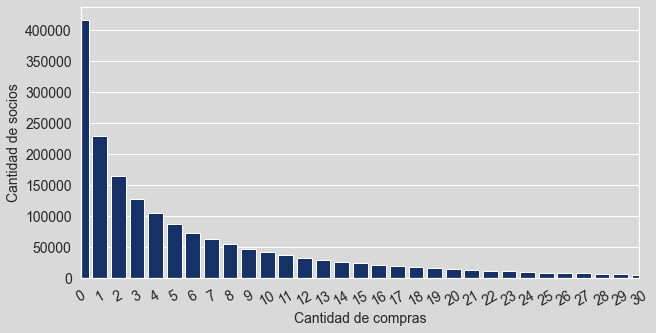

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30,labelsize=14)
ax.tick_params(axis='y',labelsize=14)
fig = sns.countplot(df[df.categoria =='ABANDONO']['cantidad_compras'], palette = ['#092D74'])

ax.set_ylabel('Cantidad de socios',loc='center',fontsize=14)
ax.set_xlabel('Cantidad de compras',loc='center',fontsize=14)
#plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0,30)

In [41]:
df[df.categoria == 'ABANDONO'].edad.describe()

count    1.858912e+06
mean     3.966101e+01
std      1.544784e+01
min      1.600000e+01
25%      2.700000e+01
50%      3.700000e+01
75%      4.900000e+01
max      1.220000e+02
Name: edad, dtype: float64

C:\Users\pnovero\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

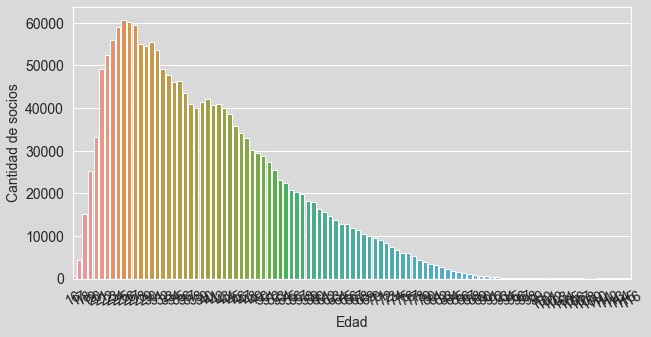

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30,labelsize=14)
ax.tick_params(axis='y',labelsize=14)
fig = sns.countplot(df[df.categoria =='ABANDONO']['edad'])

ax.set_ylabel('Cantidad de socios',loc='center',fontsize=14)
ax.set_xlabel('Edad',loc='center',fontsize=14)
#plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0,100)

C:\Users\pnovero\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

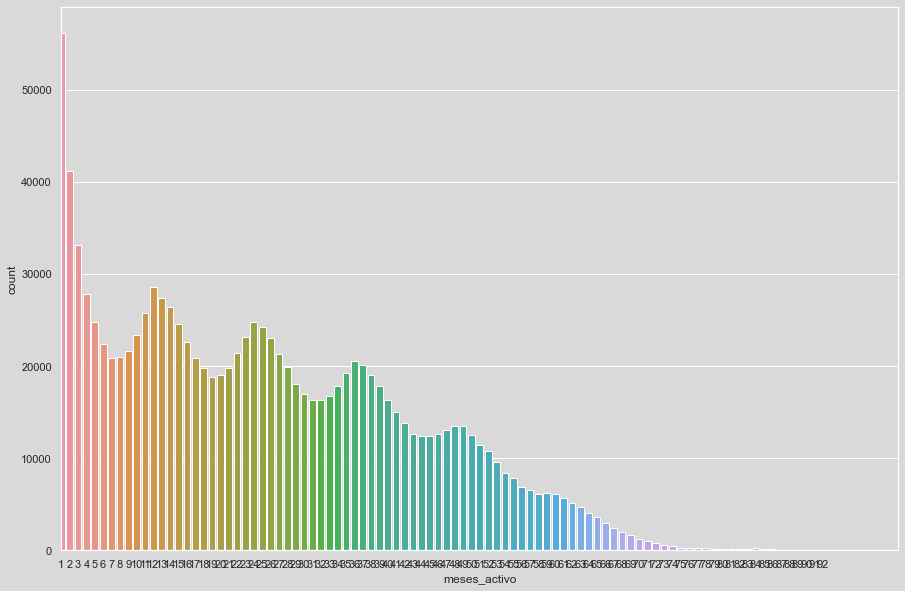

In [44]:
plt.figure(figsize=(15,10))
sns.countplot(df[(df.categoria =='ABANDONO')&(df['meses_activo']>=1)]['meses_activo'])
plt.xlim(0,100)

In [45]:
df[df.categoria =='ABANDONO']['meses_activo'].value_counts(normalize=True)*100

0     37.112999
1      3.022790
2      2.213553
3      1.785076
12     1.540202
4      1.496305
13     1.471829
14     1.419863
11     1.385595
24     1.331478
5      1.330671
15     1.321364
25     1.305226
10     1.258048
23     1.243362
26     1.238897
16     1.214151
6      1.204791
9      1.162938
22     1.153255
27     1.144971
8      1.127649
7      1.124206
17     1.123722
36     1.102419
37     1.080309
28     1.067775
18     1.066484
21     1.065354
35     1.032593
20     1.023932
38     1.022265
19     1.014518
29     0.972289
39     0.959325
34     0.957765
30     0.913868
33     0.898214
32     0.880192
40     0.878202
31     0.877287
41     0.806439
42     0.740379
48     0.724348
49     0.723273
47     0.703261
43     0.680828
46     0.680398
50     0.671360
44     0.670231
45     0.665120
51     0.617404
52     0.577004
53     0.514279
54     0.452308
55     0.423097
56     0.369571
57     0.349559
59     0.334551
58     0.331215
60     0.329655
61     0.304318
62     0

In [47]:
df[(df.categoria =='ABANDONO')&(df['meses_activo']>=1)]['meses_activo'].value_counts(normalize=True)*100

1     4.806700
2     3.519889
3     2.838546
12    2.449158
4     2.379356
13    2.340434
14    2.257800
11    2.203310
24    2.117254
5     2.115971
15    2.101172
25    2.075510
10    2.000489
23    1.977136
26    1.970036
16    1.930687
6     1.915803
9     1.849251
22    1.833853
27    1.820680
8     1.793135
7     1.787660
17    1.786890
36    1.753016
37    1.717858
28    1.697927
18    1.695874
21    1.694077
35    1.641982
20    1.628210
38    1.625558
19    1.613240
29    1.546089
39    1.525474
34    1.522993
30    1.453190
33    1.428298
32    1.399641
40    1.396476
31    1.395022
41    1.282363
42    1.177317
48    1.151825
49    1.150115
47    1.118293
43    1.082622
46    1.081937
50    1.067566
44    1.065770
45    1.057643
51    0.981768
52    0.917525
53    0.817783
54    0.719239
55    0.672789
56    0.587675
57    0.555853
59    0.531987
58    0.526683
60    0.524202
61    0.483912
62    0.442339
63    0.405470
64    0.349354
65    0.305813
66    0.256798
67    0.21

In [49]:
print('Mediana de meses activo para socios perdidos:',df[(df.categoria == 'ABANDONO') & (df.meses_activo >0)].meses_activo.median())
print('Media de meses activo para socios perdidos:',df[(df.categoria == 'ABANDONO')&(df.meses_activo >0)].meses_activo.mean())

Mediana de meses activo para socios perdidos: 23.0
Media de meses activo para socios perdidos: 25.305439455814902


In [11]:
df.head(2)

,CustomerId,kilos,meses_desde_alta,meses_activo,meses_desde_ult_compra,cantidad_compras,cantidad_promos,categoria,kilos_ult_año,GenderCode,BirthDate,fecha_activacion,ultima_compra,edad,lifetime_value_año
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,31.120,102,100,102,58,2,PLATA,0.820,Female,1984-06-21,2013-12-03,2022-04-03,37,3.73440
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,94.061,103,100,103,28,10,ORO,20.995,Male,1975-05-12,2013-11-29,2022-03-21,47,11.28732


¿Cuando se fueron dando de baja los socios que nos abandonaron?

In [133]:
df.head(2)

,CustomerId,kilos,meses_desde_alta,meses_activo,meses_desde_ult_compra,cantidad_compras,cantidad_promos,categoria,GenderCode,BirthDate,fecha_activacion,ultima_compra,fecha_baja
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,31.120,101,100,101,58,2,PLATA,Female,1984-06-21,2013-12-03,2022-04-03,2020-04-03
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,94.061,102,100,102,28,10,ALERTA DE CONSUMO,Male,1975-05-12,2013-11-29,2022-03-21,2020-03-21


In [12]:
df['ultima_compra'] = pd.to_datetime(df['ultima_compra'])
df['fecha_baja'] = df['ultima_compra'] + pd.DateOffset(months=12)

In [30]:
baja_por_mes=df[df.categoria == 'ABANDONO'].groupby(pd.Grouper(key='fecha_baja',axis=0,freq='M')).CustomerId.count().reset_index()

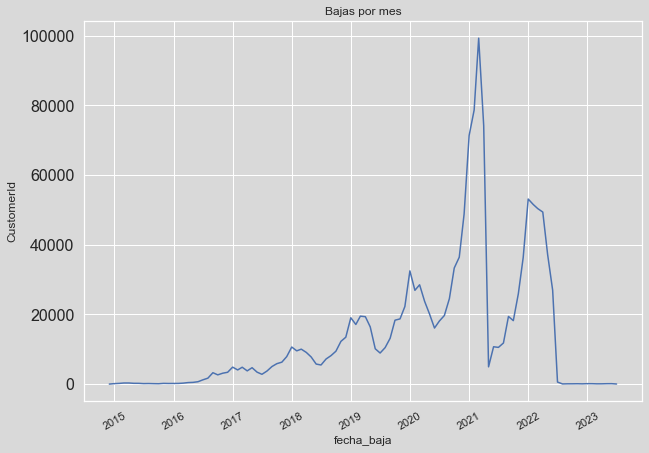

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('Bajas por mes')
fig = sns.lineplot(data=baja_por_mes, y='CustomerId',x='fecha_baja')
ax.tick_params(axis='y', labelsize=16)

In [17]:
baja_por_anio=df[df.categoria == 'ABANDONO'].groupby(pd.Grouper(key='fecha_baja',axis=0,freq='Y')).CustomerId.count().reset_index()

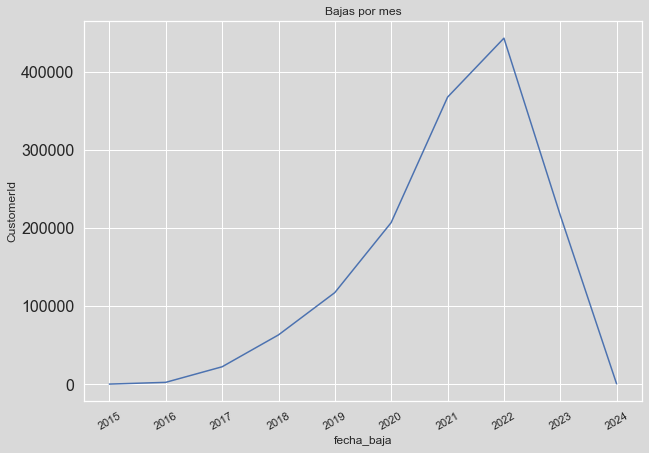

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('Bajas por mes')
fig = sns.lineplot(data=baja_por_anio, y='CustomerId',x='fecha_baja')
ax.tick_params(axis='y', labelsize=16)

In [31]:
ultima_compra_por_mes=df[df.categoria == 'ABANDONO'].groupby(pd.Grouper(key='ultima_compra',axis=0,freq='M')).CustomerId.count().reset_index()

Text(0.5, 0, '')

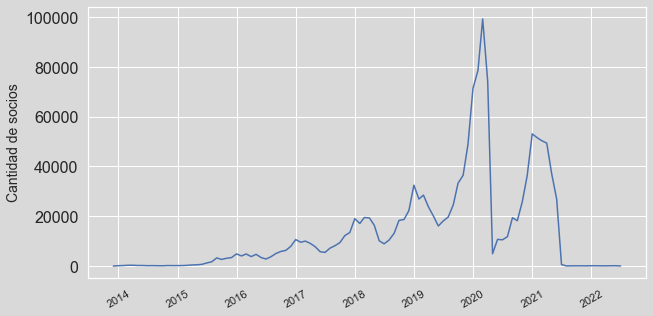

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('', fontsize=22)
fig = sns.lineplot(data=ultima_compra_por_mes, y='CustomerId',x='ultima_compra')
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('Cantidad de socios',loc='center',fontsize=14)
ax.set_xlabel('',loc='center',fontsize=14)

In [32]:
df['fecha_activacion'] = pd.to_datetime(df.fecha_activacion)
socios_activos_por_mes=df.groupby(pd.Grouper(key='fecha_activacion',axis=0,freq='M')).CustomerId.count().reset_index()
socios_activos_por_mes['socios_alta'] = socios_activos_por_mes.CustomerId.cumsum()
socios_activos_por_mes.drop(columns=['CustomerId'],inplace=True)
socios_activos_por_mes.head(2)

,fecha_activacion,socios_alta
0,2013-11-30,119
1,2013-12-31,5445


In [33]:
baja_por_mes.head(2)

,fecha_baja,CustomerId
0,2014-11-30,1
1,2014-12-31,133


In [34]:
baja_por_mes = baja_por_mes.merge(socios_activos_por_mes,left_on='fecha_baja',right_on='fecha_activacion',how='left')
baja_por_mes.dropna(inplace=True)
baja_por_mes.head(5)

,fecha_baja,CustomerId,fecha_activacion,socios_alta
0,2014-11-30,1,2014-11-30,38981.0
1,2014-12-31,133,2014-12-31,42715.0
2,2015-01-31,205,2015-01-31,52587.0
3,2015-02-28,314,2015-02-28,68296.0
4,2015-03-31,316,2015-03-31,90125.0


In [36]:
baja_por_mes.drop(columns=['fecha_activacion'],inplace=True)
baja_por_mes.columns=['fecha_baja', 'socios_baja', 'socios_alta']
baja_por_mes['tasa_abandono'] = round(baja_por_mes.socios_baja/baja_por_mes.socios_alta*100,1)
baja_por_mes.head()

,fecha_baja,socios_baja,socios_alta,tasa_abandono
0,2014-11-30,1,38981.0,0.0
1,2014-12-31,133,42715.0,0.3
2,2015-01-31,205,52587.0,0.4
3,2015-02-28,314,68296.0,0.5
4,2015-03-31,316,90125.0,0.4


Text(0.5, 0, '')

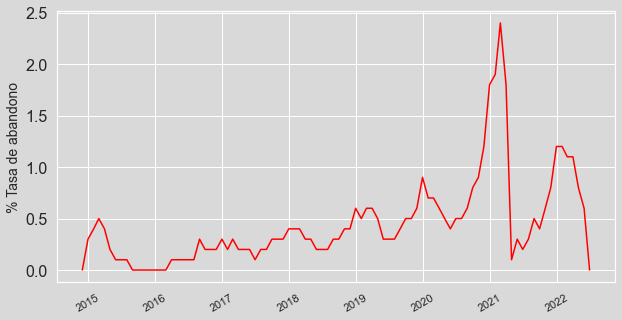

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('', fontsize=22)
fig = sns.lineplot(data=baja_por_mes, y='tasa_abandono',x='fecha_baja',color='red')
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('% Tasa de abandono',loc='center',fontsize=14)
ax.set_xlabel('',loc='center',fontsize=14)

In [38]:
print('La tasa de abandono mensual promedio del Club Grido desde su creación es del:',round(baja_por_mes.tasa_abandono.mean(),2),'%')
print('La tasa de abandono mensual promedio del Club Grido antes de la pandemia fue del :',round(baja_por_mes[baja_por_mes.fecha_baja < dt.datetime(2020,3,15)].tasa_abandono.mean(),2),'%')
print('La tasa de abandono mensual promedio del Club Grido en la ultima temporada fue del :',round(baja_por_mes[(baja_por_mes.fecha_baja >= dt.datetime(2021,5,1)) & (baja_por_mes.fecha_baja < dt.datetime(2022,5,1))].tasa_abandono.mean(),2),'%')

La tasa de abandono mensual promedio del Club Grido desde su creación es del: 0.45 %
La tasa de abandono mensual promedio del Club Grido antes de la pandemia fue del : 0.28 %
La tasa de abandono mensual promedio del Club Grido en la ultima temporada fue del : 0.71 %


In [39]:
baja_por_mes.tail(3)

,fecha_baja,socios_baja,socios_alta,tasa_abandono
89,2022-04-30,37180,4533309.0,0.8
90,2022-05-31,26962,4556648.0,0.6
91,2022-06-30,587,4556732.0,0.0


In [40]:
baja_por_mes['temporada']= np.where(baja_por_mes.fecha_baja.dt.month<5,\
                                    [' '.join([str(x), '-', str(y)]) for x, y in zip((baja_por_mes.fecha_baja.dt.year-1), (baja_por_mes.fecha_baja.dt.year))],\
                                   [' '.join([str(x), '-', str(y)]) for x, y in zip((baja_por_mes.fecha_baja.dt.year), (baja_por_mes.fecha_baja.dt.year+1))])

In [42]:
bajas_por_temp = baja_por_mes.groupby('temporada',as_index=False).agg({'socios_baja':'sum','socios_alta':['mean','max']})
bajas_por_temp.head()

temporada socios_baja   socios_alta           
                       sum          mean        max
0  2014 - 2015        1193  6.727033e+04   110918.0
1  2015 - 2016        2707  5.300248e+05   974831.0
2  2016 - 2017       38325  1.470630e+06  1919882.0
3  2017 - 2018       82166  2.345408e+06  2764308.0
4  2018 - 2019      153203  3.092902e+06  3371036.0

In [45]:
#bajas_por_temp.columns.droplevel(0)
bajas_por_temp.columns = ['temporada','socios_baja','prom_alta','max_alta']

In [47]:
bajas_por_temp['churn_anual_mean'] = round(bajas_por_temp.socios_baja / bajas_por_temp.prom_alta * 100,1)
bajas_por_temp['churn_anual_max'] = round(bajas_por_temp.socios_baja / bajas_por_temp.max_alta * 100,1)
bajas_por_temp.head()

,temporada,socios_baja,prom_alta,max_alta,churn_anual_mean,churn_anual_max
0,2014 - 2015,1193,6.727033e+04,110918.0,1.8,1.1
1,2015 - 2016,2707,5.300248e+05,974831.0,0.5,0.3
2,2016 - 2017,38325,1.470630e+06,1919882.0,2.6,2.0
3,2017 - 2018,82166,2.345408e+06,2764308.0,3.5,3.0
4,2018 - 2019,153203,3.092902e+06,3371036.0,5.0,4.5


Text(0.5, 0, '')

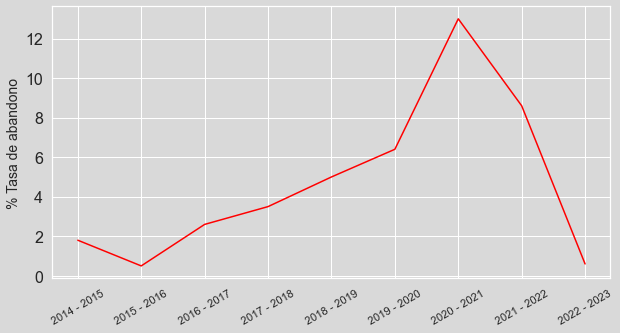

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('', fontsize=22)
fig = sns.lineplot(data=bajas_por_temp, y='churn_anual_mean',x='temporada',color='red')
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('% Tasa de abandono',loc='center',fontsize=14)
ax.set_xlabel('',loc='center',fontsize=14)

Text(0.5, 0, '')

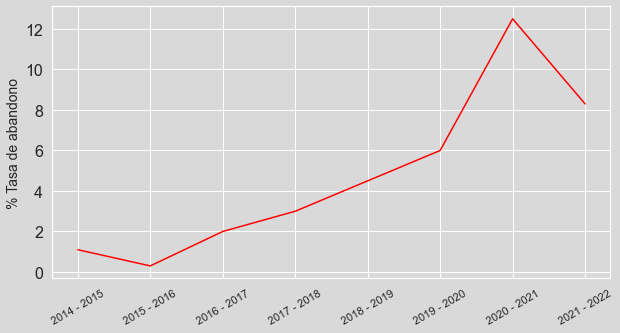

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('', fontsize=22)
fig = sns.lineplot(data=bajas_por_temp[~bajas_por_temp.temporada.str.contains('2022 - 2023')], y='churn_anual_max',x='temporada',color='red')
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('% Tasa de abandono',loc='center',fontsize=14)
ax.set_xlabel('',loc='center',fontsize=14)

In [56]:
bajas_por_temp

,temporada,socios_baja,prom_alta,max_alta,churn_anual_mean,churn_anual_max
0,2014 - 2015,1193,6.727033e+04,110918.0,1.8,1.1
1,2015 - 2016,2707,5.300248e+05,974831.0,0.5,0.3
2,2016 - 2017,38325,1.470630e+06,1919882.0,2.6,2.0
3,2017 - 2018,82166,2.345408e+06,2764308.0,3.5,3.0
4,2018 - 2019,153203,3.092902e+06,3371036.0,5.0,4.5
5,2019 - 2020,233832,3.655838e+06,3918720.0,6.4,6.0
6,2020 - 2021,525427,4.038469e+06,4190225.0,13.0,12.5
7,2021 - 2022,374533,4.365478e+06,4533309.0,8.6,8.3
8,2022 - 2023,27549,4.556690e+06,4556732.0,0.6,0.6
